# Préparation des données

In [ ]:
import pandas as pd
from google.colab import drive
drive.mount("/content/drive")

# On spécifiez le chemin du fichier CSV
#chemin_fichier_csv = '/content/drive/MyDrive/Digisport/Apprentissage profond/Data_AP.csv' #Chemin Arthur
chemin_fichier_csv = '/content/drive/MyDrive/Colab Notebooks/Devoir_AP/Data_AP.csv' #Chemin Romain
# On utilise la fonction read_csv avec header=0 pour indiquer que la première ligne contient les noms des variables
donnees = pd.read_csv(chemin_fichier_csv, header=0)

# Chemin pour les correcteurs
# donnees = pd.read_csv("Data_AP.csv",header=0)

# Affichage des premières lignes du DataFrame
print(donnees.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
  EQUIPE_DOMICILE EQUIPE_EXTERIEUR  JOURNEE SCORE  1ERE_PERIODE_NBR_BUTS  \
0              OL       AC AJACCIO        1   2-1                      3   
1      STRASBOURG        AS MONACO        1   1-2                      1   
2        CLERMONT              PSG        1   0-5                      3   
3     TOULOUSE FC         OGC NICE        1   1-1                      1   
4      ANGERS SCO        FC NANTES        1   0-0                      0   

   2EME_PERIODE_NBR_BUTS  
0                      0  
1                      2  
2                      2  
3                      1  
4                      0  


In [ ]:

# Création d'une fonction pour obtenir le nombre de buts en première mi-temps et deuxième mi-temps pour les 5 derniers matchs d'une équipe
def buts_derniers_matchs(row, equipe_col, buts_mi_temps_col, num_match):
    equipe = row[equipe_col]
    derniers_matchs = donnees[(donnees['EQUIPE_DOMICILE'] == equipe) | (donnees['EQUIPE_EXTERIEUR'] == equipe)].head(5)
    buts_mi_temps = derniers_matchs[buts_mi_temps_col].tolist()
    # Remplir avec des zéros si moins de 5 matchs ont été joués
    buts_mi_temps += [0] * (5 - len(buts_mi_temps))
    return buts_mi_temps[-num_match]

# Ajout d'une colonne pour chaque statistique de buts en première mi-temps pour les 5 derniers matchs de chaque équipe
for i in range(1, 6):
    donnees[f'dernier_match_{i}_buts_mi_temps1_dom'] = donnees.apply(lambda row: buts_derniers_matchs(row, 'EQUIPE_DOMICILE', '1ERE_PERIODE_NBR_BUTS', i), axis=1)
    donnees[f'dernier_match_{i}_buts_mi_temps1_ext'] = donnees.apply(lambda row: buts_derniers_matchs(row, 'EQUIPE_EXTERIEUR', '1ERE_PERIODE_NBR_BUTS', i), axis=1)

# Ajout d'une colonne pour chaque statistique de buts en deuxième mi-temps pour les 5 derniers matchs de chaque équipe
for i in range(1, 6):
    donnees[f'dernier_match_{i}_buts_mi_temps2_dom'] = donnees.apply(lambda row: buts_derniers_matchs(row, 'EQUIPE_DOMICILE', '2EME_PERIODE_NBR_BUTS', i), axis=1)
    donnees[f'dernier_match_{i}_buts_mi_temps2_ext'] = donnees.apply(lambda row: buts_derniers_matchs(row, 'EQUIPE_EXTERIEUR', '2EME_PERIODE_NBR_BUTS', i), axis=1)

In [ ]:
# Filtrer les données à partir de la JOURNEE = 6
donnees_modele = donnees[donnees['JOURNEE'] >= 6]

df = pd.DataFrame(donnees_modele)

df = df.iloc[:,4:]

# Sauvegarder le DataFrame dans un fichier CSV
df.to_csv('Data_ligue1.csv', index=False)

df.head()
# Affichage de la taille de notre jeu de données
df.shape

print(df)

     1ERE_PERIODE_NBR_BUTS  2EME_PERIODE_NBR_BUTS  \
50                       1                      1   
51                       2                      3   
52                       1                      2   
53                       2                      2   
54                       0                      1   
..                     ...                    ...   
375                      1                      0   
376                      4                      0   
377                      4                      1   
378                      1                      3   
379                      0                      2   

     dernier_match_1_buts_mi_temps1_dom  dernier_match_1_buts_mi_temps1_ext  \
50                                    1                                   0   
51                                    1                                   2   
52                                    1                                   1   
53                                    1        

**Présentation des données**

L'objectif de notre travail est de prédire le nombre de buts en deuxième période dans un match de football de ligue 1 sur la saison 2022-2023. Pour cela, nous avons le nombre de buts en première période du match ainsi que le nombre de buts en première et seconde période des 5 derniers matchs de chaque équipe disputant le match. Nous avons donc 21 variables explicatives et une variable à prédire (le nombre de buts en deuxième période). Nous avons un jeu de données avec 330 matchs.
Nous avons transformé la variable à prédire y en variable catégorielle pour la traiter comme des classes. Nous avons vu qu'il y avait au maximum 6 buts par mi-temps. Nous avons donc 7 classes (en comptant les mi-temps avec 0 buts) possibles de sortie pour nos différents modèles.

# Partie Traitement Modèle

In [ ]:
# Instalation des librairies nécessaire au bon fonctionnement des opérations à suivre pour ce travail
!pip install keras_core
!pip install pandas
!pip install numpy
!pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 6.0 MB/s eta 0:00:00


In [ ]:
# Importation de la librairie keras_core pour notre fichier
import keras_core as keras
from keras.models import Sequential
from keras.layers import Dense, InputLayer

Using TensorFlow backend


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils import to_categorical


def prepare_data(df):
    # Séparation des caractéristiques et de la cible pour notre prédiction
    features = df.drop('2EME_PERIODE_NBR_BUTS', axis=1)
    target = df['2EME_PERIODE_NBR_BUTS']

    # Encodage one-hot de toutes les variables catégorielles
    features = pd.get_dummies(features)

    # Normalisation des caractéristiques avec MinMaxScaler
    scaler = MinMaxScaler()
    features_scaled = scaler.fit_transform(features)

    # Encodage de la variable cible en données catégorielles
    target_encoded = to_categorical(target)

    # Séparation des données en ensembles d'entraînement et de test
    x_train, x_test, y_train, y_test = train_test_split(features_scaled, target_encoded, test_size=0.2, random_state=42)

    return x_train, x_test, y_train, y_test

# Appliquetion de cette fonction à notre DataFrame
x_train, x_test, y_train, y_test = prepare_data(df)
print(y_train.shape)
print(x_train.shape)



(264, 7)
(264, 21)


In [ ]:
# Construction d'un premier modèle avec comme optimiseur adam et seulement 1 couche de sortie
import tensorflow as tf

x_train, x_test, y_train, y_test = prepare_data(df)

input_layer = InputLayer(input_shape=x_train.shape[1:])
output_layer = Dense(units=y_train.shape[1], activation="softmax")

model = Sequential([
    input_layer,
    output_layer
])
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(x_train, y_train, epochs=10, batch_size=100, verbose=2)

Epoch 1/10
3/3 - 2s - loss: 1.9631 - accuracy: 0.2008 - 2s/epoch - 534ms/step
Epoch 2/10
3/3 - 0s - loss: 1.9406 - accuracy: 0.2045 - 25ms/epoch - 8ms/step
Epoch 3/10
3/3 - 0s - loss: 1.9192 - accuracy: 0.2121 - 32ms/epoch - 11ms/step
Epoch 4/10
3/3 - 0s - loss: 1.8980 - accuracy: 0.2235 - 59ms/epoch - 20ms/step
Epoch 5/10
3/3 - 0s - loss: 1.8787 - accuracy: 0.2235 - 33ms/epoch - 11ms/step
Epoch 6/10
3/3 - 0s - loss: 1.8602 - accuracy: 0.2235 - 39ms/epoch - 13ms/step
Epoch 7/10
3/3 - 0s - loss: 1.8430 - accuracy: 0.2348 - 38ms/epoch - 13ms/step
Epoch 8/10
3/3 - 0s - loss: 1.8260 - accuracy: 0.2462 - 24ms/epoch - 8ms/step
Epoch 9/10
3/3 - 0s - loss: 1.8104 - accuracy: 0.2500 - 21ms/epoch - 7ms/step
Epoch 10/10
3/3 - 0s - loss: 1.7958 - accuracy: 0.2462 - 25ms/epoch - 8ms/step


In [ ]:
# Construction d'un modèle avec 1 couche cachée ayant pour fonction d'activation 'relu'
model = Sequential([
    InputLayer(input_shape=x_train.shape[1:]),
    Dense(units=128, activation="relu"),
    Dense(units=y_train.shape[1], activation="softmax")
])
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
i=model.fit(x_train, y_train, epochs=50, batch_size=100, verbose=2,validation_data=(x_test, y_test))

Epoch 1/50
3/3 - 4s - loss: 2.0444 - accuracy: 0.1174 - val_loss: 1.9468 - val_accuracy: 0.1212 - 4s/epoch - 1s/step
Epoch 2/50
3/3 - 0s - loss: 1.9356 - accuracy: 0.1364 - val_loss: 1.8439 - val_accuracy: 0.1970 - 166ms/epoch - 55ms/step
Epoch 3/50
3/3 - 0s - loss: 1.8416 - accuracy: 0.2045 - val_loss: 1.7579 - val_accuracy: 0.3636 - 180ms/epoch - 60ms/step
Epoch 4/50
3/3 - 0s - loss: 1.7668 - accuracy: 0.3144 - val_loss: 1.6870 - val_accuracy: 0.4091 - 149ms/epoch - 50ms/step
Epoch 5/50
3/3 - 0s - loss: 1.7023 - accuracy: 0.3220 - val_loss: 1.6313 - val_accuracy: 0.4091 - 130ms/epoch - 43ms/step
Epoch 6/50
3/3 - 0s - loss: 1.6528 - accuracy: 0.3371 - val_loss: 1.5887 - val_accuracy: 0.4091 - 155ms/epoch - 52ms/step
Epoch 7/50
3/3 - 0s - loss: 1.6149 - accuracy: 0.3409 - val_loss: 1.5569 - val_accuracy: 0.3939 - 216ms/epoch - 72ms/step
Epoch 8/50
3/3 - 0s - loss: 1.5856 - accuracy: 0.3409 - val_loss: 1.5345 - val_accuracy: 0.3788 - 133ms/epoch - 44ms/step
Epoch 9/50
3/3 - 0s - loss: 1

**Justification de l'architecture**

Nous avons tout d'abord choisi une architecture de modèle à deux couches pour résoudre notre problème de prédiction du nombre de buts en deuxième période, en prenant en compte le nombre de buts en première période et les statistiques des cinq matchs précédents de chaque équipe. Notre décision a été guidée par plusieurs considérations.

Pour commencer, la première couche Dense avec une activation ReLU vise à introduire de la non-linéarité dans le modèle, permettant ainsi la capture de motifs complexes dans les données. Nous avons opté pour la fonction d'activation ReLU en raison de son efficacité dans la modélisation des relations non linéaires, tout en évitant les problèmes liés à la disparition du gradient.

On peut redéfinir notre problème comme étant un problème de classification où chaque classe correspond à un nombre de buts. En effet, on souhaite savoir à quelle classe appartient chaque observation (classe 1 = 0 buts, classe 2 = 1 but). Nous pouvons utiliser la fonction d'activation softmax en sortie car nous avons modifié nos données de sortie pour les traiter sous formes de classes.

La deuxième couche Dense, représentant la couche de sortie, utilise une activation softmax. Softmax est généralement réservée aux tâches de classification où la somme des probabilités des classes est égale à 1. Néanmoins, pour les prédictions de nombres de buts, une activation linéaire pourrait être pertinente car elle permet de prédire des valeurs numériques sans imposer de contraintes de probabilité. Néanmoins, l'utilisation de la fonction d'activation linéaire dans une couche est généralement associée à une transformation linéaire des données d'entrée. Cela signifie que la couche n'ajoute pas de non-linéarité au modèle. Si l'on utilise uniquement des couches avec des activations linéaires, le modèle résultant reste linéaire, quel que soit le nombre de couches. L'introduction de non-linéarité dans les réseaux de neurones est cruciale pour permettre au modèle d'apprendre des relations complexes dans les données comme dans la prédiction du nombre de buts dans un match de foot. Nous avons donc conservé la fonction d'activation softmax.

Concernant l'optimizer, "Adam" (Adaptive Moment Estimation) est un optimiseur stochastique qui adapte les taux d'apprentissage des différents paramètres du modèle. Il combine des idées de l'optimiseur "RMSProp" avec des méthodes de moyenne mobile pour les gradients. "Adam" est réputé pour être efficace dans la plupart des cas. Nous avons essayé différents optimiseurs comme "sgd" mais c'est cet optimiseur qui nous permettait d'obtenir les meilleurs résultats.

En ce qui concerne la fonction de perte, nous avons opté pour "categorical_crossentropy". Cette fonction de perte est généralement utilisée dans les problèmes de classification multiclasse où chaque exemple peut appartenir à une seule classe parmi plusieurs classes. C'est une fonction de perte couramment utilisée pour les problèmes de classification multiclasse avec des sorties "softmax".

En résumé, notre architecture de modèle à deux couches vise à équilibrer la complexité nécessaire pour capturer des motifs significatifs tout en évitant le surapprentissage.

En ce qui concerne la fonction de perte, nous avons opté pour "mean_squared_error" pour refléter notre objectif de prédire une valeur numérique plutôt que des classes discrètes. Cette fonction de perte est adaptée à notre problème de régression où nous cherchons à minimiser la différence entre les prédictions du nombre de buts de notre modèle et les valeurs réelles.

En résumé, notre architecture de modèle à deux couches vise à équilibrer la complexité nécessaire pour capturer des motifs significatifs tout en évitant le surapprentissage.

In [ ]:
# Création d'un nouveau modèle ayant 2 couches cachées
model = Sequential([
    InputLayer(input_shape=x_train.shape[1:]),
    Dense(units=128, activation="relu"),
    Dense(units=128, activation="relu"),
    Dense(units=y_train.shape[1], activation="softmax")
])
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(x_train, y_train, epochs=50, batch_size=32, verbose=2,validation_data=(x_test, y_test))

Epoch 1/50
9/9 - 3s - loss: 1.8118 - accuracy: 0.2803 - val_loss: 1.6677 - val_accuracy: 0.3182 - 3s/epoch - 353ms/step
Epoch 2/50
9/9 - 0s - loss: 1.5964 - accuracy: 0.3485 - val_loss: 1.5488 - val_accuracy: 0.2273 - 115ms/epoch - 13ms/step
Epoch 3/50
9/9 - 0s - loss: 1.5042 - accuracy: 0.3750 - val_loss: 1.4843 - val_accuracy: 0.3636 - 240ms/epoch - 27ms/step
Epoch 4/50
9/9 - 0s - loss: 1.4686 - accuracy: 0.3864 - val_loss: 1.4835 - val_accuracy: 0.3182 - 180ms/epoch - 20ms/step
Epoch 5/50
9/9 - 0s - loss: 1.4516 - accuracy: 0.4129 - val_loss: 1.5069 - val_accuracy: 0.2727 - 166ms/epoch - 18ms/step
Epoch 6/50
9/9 - 0s - loss: 1.4332 - accuracy: 0.4280 - val_loss: 1.5231 - val_accuracy: 0.2727 - 102ms/epoch - 11ms/step
Epoch 7/50
9/9 - 0s - loss: 1.4229 - accuracy: 0.4280 - val_loss: 1.5349 - val_accuracy: 0.2879 - 103ms/epoch - 11ms/step
Epoch 8/50
9/9 - 0s - loss: 1.4040 - accuracy: 0.4394 - val_loss: 1.5333 - val_accuracy: 0.3030 - 95ms/epoch - 11ms/step
Epoch 9/50
9/9 - 0s - loss:

In [ ]:
# On construit ensuite un modèle avec 3 couches cachées
model = Sequential([
    InputLayer(input_shape=x_train.shape[1:]),
    Dense(units=128, activation="relu"),
    Dense(units=128, activation="relu"),
    Dense(units=128, activation="relu"),
    Dense(units=y_train.shape[1], activation="softmax")
])
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(x_train, y_train, epochs=50, batch_size=32, verbose=2,validation_data=(x_test, y_test))

Epoch 1/50
9/9 - 3s - loss: 1.8867 - accuracy: 0.1894 - val_loss: 1.7338 - val_accuracy: 0.2424 - 3s/epoch - 357ms/step
Epoch 2/50
9/9 - 0s - loss: 1.6617 - accuracy: 0.3144 - val_loss: 1.5240 - val_accuracy: 0.3030 - 101ms/epoch - 11ms/step
Epoch 3/50
9/9 - 0s - loss: 1.5266 - accuracy: 0.3523 - val_loss: 1.4581 - val_accuracy: 0.3939 - 94ms/epoch - 10ms/step
Epoch 4/50
9/9 - 0s - loss: 1.4915 - accuracy: 0.3674 - val_loss: 1.4667 - val_accuracy: 0.2727 - 96ms/epoch - 11ms/step
Epoch 5/50
9/9 - 0s - loss: 1.4710 - accuracy: 0.4167 - val_loss: 1.4578 - val_accuracy: 0.3333 - 79ms/epoch - 9ms/step
Epoch 6/50
9/9 - 0s - loss: 1.4429 - accuracy: 0.4394 - val_loss: 1.5149 - val_accuracy: 0.2121 - 94ms/epoch - 10ms/step
Epoch 7/50
9/9 - 0s - loss: 1.4443 - accuracy: 0.3636 - val_loss: 1.5077 - val_accuracy: 0.2424 - 95ms/epoch - 11ms/step
Epoch 8/50
9/9 - 0s - loss: 1.4152 - accuracy: 0.4356 - val_loss: 1.5125 - val_accuracy: 0.3182 - 100ms/epoch - 11ms/step
Epoch 9/50
9/9 - 0s - loss: 1.39

L'ajout de couches intermédiaires dans le modèle a été motivé par la volonté d'augmenter sa capacité à apprendre des motifs complexes des données. En introduisant plusieurs couches Dense avec des activations Relu, on offre au réseau neuronal la possibilité de découvrir des caractéristiques abstraites et non linéaires, ce qui est particulièrement pertinent pour la prédiction du nombre de buts en deuxième périosz. Bien que les résultats d'entraînement aient montré une amélioration, il est important de noter que cela est du vraisemblablement au sur-apprentissage. En effet, la qualité de prédiction des données d'entraînement augmente considérablement lorsque l'on augmente le nombre de couches intermédiaires et d'epochs. Néanmoins, les prédictions des données tests sont elles très mauvaises (accuracy proche de 0.2) là ou les prédictions des données d'entraînements sont très bonnes (accuracy allant à plus de 90%). Cela indique que le modèle a appris des détails spécifiques aux données d'entraînement qui pourraient ne pas se généraliser efficacement à de nouvelles données. Cette architecture de modèle n'est donc pas adaptée. De plus, le modèle ne converge pas. L'absence de convergence indique souvent des problèmes tels que des hyperparamètres mal réglés, une architecture inappropriée ou un manque de données, compromettant la capacité du modèle à généraliser correctement aux nouvelles observations. La convergence est cruciale pour obtenir des performances fiables et interprétables du modèle. Dans notre cas, c'est un problème d'architecture.

**Comparaison des modèles avec 1, 2 et 3 couches cachées**

En analysant les particularités de ces 3 modèles, on constate que les résultats pour les données d'entraînements sont nettements supèrieurs pour le modèle avec 3 couches cachées. Néanmoins, les prédictions pour les données de validations sont davantages précises pour le modèle avec 1 couche cachée. Nous faisons face à un problème de sur-apprentissage avec le modèle avec 3 couches cachées. Par conséquent, ce serait le modèle avec 1 couche cachée qui serait le plus performant selon nous et qui apporterait des résultats plus fiables.


In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 128)               2816      
                                                                 
 dense_7 (Dense)             (None, 128)               16512     
                                                                 
 dense_8 (Dense)             (None, 128)               16512     
                                                                 
 dense_9 (Dense)             (None, 7)                 903       
                                                                 
Total params: 36743 (143.53 KB)
Trainable params: 36743 (143.53 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# On construit une modèle à 1 couche caché en considérant un sous-échantillon de nos données (30%) afin d'en évaluer le modèle
model = Sequential([
    InputLayer(input_shape=x_train.shape[1:]),
    Dense(units=128, activation="relu"),
    Dense(units=y_train.shape[1], activation="softmax")
])
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(x_train, y_train, epochs=50, batch_size=100, verbose=2, validation_split=.3)

Epoch 1/50
2/2 - 1s - loss: 1.9507 - accuracy: 0.1630 - val_loss: 1.9099 - val_accuracy: 0.2000 - 1s/epoch - 629ms/step
Epoch 2/50
2/2 - 0s - loss: 1.8974 - accuracy: 0.2174 - val_loss: 1.8623 - val_accuracy: 0.2625 - 60ms/epoch - 30ms/step
Epoch 3/50
2/2 - 0s - loss: 1.8474 - accuracy: 0.2554 - val_loss: 1.8188 - val_accuracy: 0.2750 - 58ms/epoch - 29ms/step
Epoch 4/50
2/2 - 0s - loss: 1.8036 - accuracy: 0.2554 - val_loss: 1.7792 - val_accuracy: 0.2750 - 65ms/epoch - 33ms/step
Epoch 5/50
2/2 - 0s - loss: 1.7631 - accuracy: 0.2663 - val_loss: 1.7446 - val_accuracy: 0.2750 - 69ms/epoch - 34ms/step
Epoch 6/50
2/2 - 0s - loss: 1.7259 - accuracy: 0.2663 - val_loss: 1.7125 - val_accuracy: 0.2875 - 57ms/epoch - 28ms/step
Epoch 7/50
2/2 - 0s - loss: 1.6935 - accuracy: 0.2826 - val_loss: 1.6835 - val_accuracy: 0.2875 - 65ms/epoch - 32ms/step
Epoch 8/50
2/2 - 0s - loss: 1.6650 - accuracy: 0.2989 - val_loss: 1.6580 - val_accuracy: 0.3000 - 67ms/epoch - 34ms/step
Epoch 9/50
2/2 - 0s - loss: 1.639

In [ ]:
# On réalise la même opération mais pour notre modèle ayant 3 couches cachées
model = Sequential([
    InputLayer(input_shape=x_train.shape[1:]),
    Dense(units=128, activation="relu"),
    Dense(units=128, activation="relu"),
    Dense(units=128, activation="relu"),
    Dense(units=y_train.shape[1], activation="softmax")
])
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(x_train, y_train, epochs=50, batch_size=100, verbose=2, validation_split=.3)

Epoch 1/50
2/2 - 1s - loss: 1.8962 - accuracy: 0.2065 - val_loss: 1.8080 - val_accuracy: 0.3375 - 1s/epoch - 543ms/step
Epoch 2/50
2/2 - 0s - loss: 1.8000 - accuracy: 0.3098 - val_loss: 1.7260 - val_accuracy: 0.3500 - 40ms/epoch - 20ms/step
Epoch 3/50
2/2 - 0s - loss: 1.7142 - accuracy: 0.3315 - val_loss: 1.6528 - val_accuracy: 0.3500 - 58ms/epoch - 29ms/step
Epoch 4/50
2/2 - 0s - loss: 1.6422 - accuracy: 0.3424 - val_loss: 1.5913 - val_accuracy: 0.3375 - 66ms/epoch - 33ms/step
Epoch 5/50
2/2 - 0s - loss: 1.5771 - accuracy: 0.3478 - val_loss: 1.5503 - val_accuracy: 0.3250 - 37ms/epoch - 19ms/step
Epoch 6/50
2/2 - 0s - loss: 1.5425 - accuracy: 0.3370 - val_loss: 1.5307 - val_accuracy: 0.3125 - 42ms/epoch - 21ms/step
Epoch 7/50
2/2 - 0s - loss: 1.5213 - accuracy: 0.3641 - val_loss: 1.5189 - val_accuracy: 0.3500 - 39ms/epoch - 20ms/step
Epoch 8/50
2/2 - 0s - loss: 1.5079 - accuracy: 0.3967 - val_loss: 1.5133 - val_accuracy: 0.3625 - 41ms/epoch - 21ms/step
Epoch 9/50
2/2 - 0s - loss: 1.501

**Comparaison des modèles avec 1 et 3 couches cachées avec 30% des données en validation**

En analysant les particularités de ces 2 modèles, on constate que les résultats pour les données d'entraînements sont supèrieurs pour le modèle avec 3 couches cachées. Néanmoins, les prédictions pour les données de validations sont relativement équivalentes pour les 2 modèles. Ensuite, il est important de souligner que lorsque l'on augmente le pourcentage de données de validation, les résultats s'équilibrent pour les modèles avec 1 et 3 couches cachées.

In [ ]:
# On va ensuite établir une variation de l'optimiseur avec le learning rate
from keras.optimizers import Adam

model = Sequential([
    InputLayer(input_shape=x_train.shape[1:]),
    Dense(units=128, activation="relu"),
    Dense(units=128, activation="relu"),
    Dense(units=128, activation="relu"),
    Dense(units=y_train.shape[1], activation="softmax")
])
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.01), metrics=["accuracy"])
h=model.fit(x_train, y_train, epochs=30, batch_size=100, verbose=2, validation_split=0.3)

Epoch 1/30
2/2 - 1s - loss: 1.7968 - accuracy: 0.1250 - val_loss: 1.5877 - val_accuracy: 0.3750 - 1s/epoch - 567ms/step
Epoch 2/30
2/2 - 0s - loss: 1.5690 - accuracy: 0.3043 - val_loss: 1.5219 - val_accuracy: 0.2500 - 40ms/epoch - 20ms/step
Epoch 3/30
2/2 - 0s - loss: 1.4964 - accuracy: 0.3315 - val_loss: 1.4866 - val_accuracy: 0.2875 - 55ms/epoch - 28ms/step
Epoch 4/30
2/2 - 0s - loss: 1.4542 - accuracy: 0.4402 - val_loss: 1.4533 - val_accuracy: 0.3875 - 37ms/epoch - 19ms/step
Epoch 5/30
2/2 - 0s - loss: 1.4107 - accuracy: 0.4402 - val_loss: 1.5283 - val_accuracy: 0.2750 - 50ms/epoch - 25ms/step
Epoch 6/30
2/2 - 0s - loss: 1.3669 - accuracy: 0.3967 - val_loss: 1.5062 - val_accuracy: 0.3000 - 58ms/epoch - 29ms/step
Epoch 7/30
2/2 - 0s - loss: 1.3508 - accuracy: 0.4620 - val_loss: 1.4778 - val_accuracy: 0.4000 - 54ms/epoch - 27ms/step
Epoch 8/30
2/2 - 0s - loss: 1.3009 - accuracy: 0.4891 - val_loss: 1.5129 - val_accuracy: 0.3125 - 39ms/epoch - 20ms/step
Epoch 9/30
2/2 - 0s - loss: 1.209

**Analyse en modifiant le learning rate**

En augmentant le learning rate, lorsqu'il est à 0.01, notre algorithme est capable de (trop) bien apprendre les données d'entraînements. Néanmoins, comme dit précédemment, les prédictions restent largement plus faibles. C'est encore un problème de sur-apprentissage. Pour palier à cela, on essaye de mettre en place une technique DropOut. La technique Dropout est une méthode de régularisation largement utilisée dans les réseaux de neurones pour prévenir le surapprentissage (overfitting). Elle consiste à aléatoirement "abandonner" (ignorer) un certain pourcentage des neurones lors de l'entraînement, c'est-à-dire les désactiver temporairement. L'idée derrière le Dropout est de forcer le réseau à ne pas dépendre trop fortement de certains neurones spécifiques, en les excluant de manière aléatoire pendant l'entraînement. Cela permet de rendre le réseau plus robuste et généralisable, car il ne peut pas se spécialiser excessivement sur certaines caractéristiques particulières des données d'entraînement

**Utilisation de la technique de régularisation DropOut pour notre jeu de données**

In [ ]:
from keras.optimizers import Adam
from keras.layers import Dropout

model = Sequential([
    InputLayer(input_shape=x_train.shape[1:]),
    Dense(units=128, activation="relu"),
    Dropout(0.5),
    Dense(units=y_train.shape[1], activation="softmax")
])
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.01), metrics=["accuracy"])
i=model.fit(x_train, y_train, epochs=50, batch_size=100, verbose=2, validation_split=0.3)

Epoch 1/50
1/1 - 1s - loss: 2.0715 - accuracy: 0.0652 - val_loss: 1.8076 - val_accuracy: 0.3750 - 1s/epoch - 1s/step
Epoch 2/50
1/1 - 0s - loss: 1.7777 - accuracy: 0.3261 - val_loss: 1.6323 - val_accuracy: 0.4500 - 144ms/epoch - 144ms/step
Epoch 3/50
1/1 - 0s - loss: 1.5847 - accuracy: 0.4022 - val_loss: 1.5285 - val_accuracy: 0.4750 - 93ms/epoch - 93ms/step
Epoch 4/50
1/1 - 0s - loss: 1.5197 - accuracy: 0.4022 - val_loss: 1.4830 - val_accuracy: 0.4750 - 102ms/epoch - 102ms/step
Epoch 5/50
1/1 - 0s - loss: 1.4568 - accuracy: 0.4022 - val_loss: 1.4799 - val_accuracy: 0.4750 - 97ms/epoch - 97ms/step
Epoch 6/50
1/1 - 0s - loss: 1.4097 - accuracy: 0.4130 - val_loss: 1.4901 - val_accuracy: 0.4750 - 99ms/epoch - 99ms/step
Epoch 7/50
1/1 - 0s - loss: 1.4285 - accuracy: 0.4348 - val_loss: 1.4927 - val_accuracy: 0.4250 - 108ms/epoch - 108ms/step
Epoch 8/50
1/1 - 0s - loss: 1.4006 - accuracy: 0.4565 - val_loss: 1.4827 - val_accuracy: 0.4000 - 68ms/epoch - 68ms/step
Epoch 9/50
1/1 - 0s - loss: 1.

**Analyse avec la technique DropOut**

En utilisant la technique DropOut, on constate bien que l'on ne sur-apprend plus comme avant. Les résultats restent plus cohérents entre les résultats pour les données d'entraînement et les prédictions de test (même si ces dernières restent moins bonnes). Dans notre cas, la technique DropOut a été efficace pour eviter le sur-apprentissage et cela a augmenté notre accuracy d'entraînement sans sur-apprendre.

**Utilisation de la technique de régularisation Ridge (L2) pour notre jeu de données**

In [ ]:
from keras.regularizers import l2

l2_penalty = 0.01

model_ridge = Sequential([
    InputLayer(input_shape=x_train.shape[1:]),
    Dense(units=128, activation="relu", kernel_regularizer=l2(l2_penalty)),
    Dense(units=y_train.shape[1], activation="softmax")
])
model_ridge.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.01), metrics=["accuracy"])
j = model_ridge.fit(x_train, y_train, epochs=30, batch_size=100, verbose=2, validation_split=0.3)


Epoch 1/30
2/2 - 1s - loss: 2.2830 - accuracy: 0.1576 - val_loss: 1.9422 - val_accuracy: 0.2625 - 855ms/epoch - 428ms/step
Epoch 2/30
2/2 - 0s - loss: 1.9087 - accuracy: 0.3098 - val_loss: 1.8357 - val_accuracy: 0.2875 - 56ms/epoch - 28ms/step
Epoch 3/30
2/2 - 0s - loss: 1.8191 - accuracy: 0.3859 - val_loss: 1.7794 - val_accuracy: 0.2625 - 37ms/epoch - 18ms/step
Epoch 4/30
2/2 - 0s - loss: 1.7661 - accuracy: 0.4239 - val_loss: 1.7112 - val_accuracy: 0.3125 - 36ms/epoch - 18ms/step
Epoch 5/30
2/2 - 0s - loss: 1.7021 - accuracy: 0.4620 - val_loss: 1.6840 - val_accuracy: 0.3250 - 57ms/epoch - 29ms/step
Epoch 6/30
2/2 - 0s - loss: 1.6537 - accuracy: 0.4783 - val_loss: 1.6796 - val_accuracy: 0.3125 - 39ms/epoch - 19ms/step
Epoch 7/30
2/2 - 0s - loss: 1.6192 - accuracy: 0.4457 - val_loss: 1.6924 - val_accuracy: 0.2375 - 57ms/epoch - 28ms/step
Epoch 8/30
2/2 - 0s - loss: 1.5830 - accuracy: 0.4239 - val_loss: 1.6803 - val_accuracy: 0.3250 - 54ms/epoch - 27ms/step
Epoch 9/30
2/2 - 0s - loss: 1.

**Analyse avec la technique Ridge**

En utilisant la technique Ridge, on remarque qu'en comparaison avec DropOut, les prédiction pour les données d'entraînement sont légèrements plus faibles, et sensiblement plus haute pour celles de validation

**Utilisation de la technique de régularisation Lasso (L2) pour notre jeu de données**

In [ ]:
from keras.regularizers import l1

l1_penalty = 0.01

model_lasso = Sequential([
    InputLayer(input_shape=x_train.shape[1:]),
    Dense(units=128, activation="relu", kernel_regularizer=l1(l1_penalty)),
    Dense(units=y_train.shape[1], activation="softmax")
])

model_lasso.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.01), metrics=["accuracy"])
k = model_lasso.fit(x_train, y_train, epochs=30, batch_size=100, verbose=2, validation_split=0.3)

Epoch 1/30
2/2 - 1s - loss: 4.7469 - accuracy: 0.0815 - val_loss: 4.1664 - val_accuracy: 0.1875 - 820ms/epoch - 410ms/step
Epoch 2/30
2/2 - 0s - loss: 3.9784 - accuracy: 0.2772 - val_loss: 3.6539 - val_accuracy: 0.2750 - 43ms/epoch - 22ms/step
Epoch 3/30
2/2 - 0s - loss: 3.5140 - accuracy: 0.3261 - val_loss: 3.2696 - val_accuracy: 0.3125 - 36ms/epoch - 18ms/step
Epoch 4/30
2/2 - 0s - loss: 3.1678 - accuracy: 0.3641 - val_loss: 2.9531 - val_accuracy: 0.3500 - 38ms/epoch - 19ms/step
Epoch 5/30
2/2 - 0s - loss: 2.8720 - accuracy: 0.3859 - val_loss: 2.6809 - val_accuracy: 0.3375 - 37ms/epoch - 19ms/step
Epoch 6/30
2/2 - 0s - loss: 2.6134 - accuracy: 0.4076 - val_loss: 2.4407 - val_accuracy: 0.3375 - 64ms/epoch - 32ms/step
Epoch 7/30
2/2 - 0s - loss: 2.3897 - accuracy: 0.4293 - val_loss: 2.2518 - val_accuracy: 0.3125 - 35ms/epoch - 17ms/step
Epoch 8/30
2/2 - 0s - loss: 2.2155 - accuracy: 0.4130 - val_loss: 2.1095 - val_accuracy: 0.2500 - 42ms/epoch - 21ms/step
Epoch 9/30
2/2 - 0s - loss: 2.

**Analyse avec la technique Lasso**

En utilisant la technique Ridge, on observe globalement des résultats également plus faible pour la précision des données entrainements, et relativement instable pour celles de tests

**Utilisation de la technique EarlyStopping**

In [ ]:
# Utilisation du callback EarlyStopping avec 1 couche cachée uniquement
from keras.callbacks import EarlyStopping

# On définit le callback EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Modèle avec une seule couche cachée
model = Sequential([
    InputLayer(input_shape=x_train.shape[1:]),
    Dense(units=128, activation="relu"),
    Dense(units=y_train.shape[1], activation="softmax")
])

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Entraînement avec EarlyStopping
history = model.fit(x_train, y_train, epochs=50, batch_size=100, verbose=2, validation_data=(x_test, y_test), callbacks=[early_stopping])


Epoch 1/50
1/1 - 1s - loss: 1.8151 - accuracy: 0.2500 - val_loss: 1.7591 - val_accuracy: 0.2727 - 985ms/epoch - 985ms/step
Epoch 2/50
1/1 - 0s - loss: 1.7826 - accuracy: 0.2955 - val_loss: 1.7351 - val_accuracy: 0.2273 - 68ms/epoch - 68ms/step
Epoch 3/50
1/1 - 0s - loss: 1.7518 - accuracy: 0.3182 - val_loss: 1.7127 - val_accuracy: 0.1818 - 65ms/epoch - 65ms/step
Epoch 4/50
1/1 - 0s - loss: 1.7228 - accuracy: 0.3182 - val_loss: 1.6919 - val_accuracy: 0.2273 - 45ms/epoch - 45ms/step
Epoch 5/50
1/1 - 0s - loss: 1.6956 - accuracy: 0.3523 - val_loss: 1.6726 - val_accuracy: 0.2273 - 64ms/epoch - 64ms/step
Epoch 6/50
1/1 - 0s - loss: 1.6701 - accuracy: 0.3864 - val_loss: 1.6547 - val_accuracy: 0.2727 - 42ms/epoch - 42ms/step
Epoch 7/50
1/1 - 0s - loss: 1.6464 - accuracy: 0.4205 - val_loss: 1.6385 - val_accuracy: 0.3182 - 72ms/epoch - 72ms/step
Epoch 8/50
1/1 - 0s - loss: 1.6243 - accuracy: 0.3864 - val_loss: 1.6239 - val_accuracy: 0.3182 - 44ms/epoch - 44ms/step
Epoch 9/50
1/1 - 0s - loss: 1.

In [ ]:
# Utilisation du callback EarlyStopping avec la technique DropOut
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import Dropout

# On définit le callback EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Modèle avec Dropout
model = Sequential([
    InputLayer(input_shape=x_train.shape[1:]),
    Dense(units=128, activation="relu"),
    Dropout(0.5),
    Dense(units=y_train.shape[1], activation="softmax")
])

model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.01), metrics=["accuracy"])

# Entraînement avec EarlyStopping
history = model.fit(x_train, y_train, epochs=30, batch_size=100, verbose=2, validation_split=0.3, callbacks=[early_stopping])


Epoch 1/30
2/2 - 1s - loss: 1.9674 - accuracy: 0.1902 - val_loss: 1.6758 - val_accuracy: 0.2250 - 783ms/epoch - 391ms/step
Epoch 2/30
2/2 - 0s - loss: 1.6919 - accuracy: 0.2391 - val_loss: 1.5942 - val_accuracy: 0.2750 - 55ms/epoch - 28ms/step
Epoch 3/30
2/2 - 0s - loss: 1.5561 - accuracy: 0.3207 - val_loss: 1.5866 - val_accuracy: 0.2500 - 53ms/epoch - 27ms/step
Epoch 4/30
2/2 - 0s - loss: 1.5715 - accuracy: 0.2880 - val_loss: 1.5567 - val_accuracy: 0.2625 - 36ms/epoch - 18ms/step
Epoch 5/30
2/2 - 0s - loss: 1.5292 - accuracy: 0.2826 - val_loss: 1.5233 - val_accuracy: 0.2875 - 38ms/epoch - 19ms/step
Epoch 6/30
2/2 - 0s - loss: 1.4859 - accuracy: 0.3804 - val_loss: 1.5169 - val_accuracy: 0.3500 - 38ms/epoch - 19ms/step
Epoch 7/30
2/2 - 0s - loss: 1.4978 - accuracy: 0.3696 - val_loss: 1.5143 - val_accuracy: 0.3500 - 40ms/epoch - 20ms/step
Epoch 8/30
2/2 - 0s - loss: 1.4603 - accuracy: 0.3804 - val_loss: 1.5210 - val_accuracy: 0.3000 - 36ms/epoch - 18ms/step
Epoch 9/30
2/2 - 0s - loss: 1.

In [ ]:
# Utilisation du callback EarlyStopping avec la technique Ridge
from keras.regularizers import l2

# On définit le callback EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

l2_penalty = 0.01

model_ridge = Sequential([
    InputLayer(input_shape=x_train.shape[1:]),
    Dense(units=128, activation="relu", kernel_regularizer=l2(l2_penalty)),
    Dense(units=y_train.shape[1], activation="softmax")
])
model_ridge.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.01), metrics=["accuracy"])
history = model_ridge.fit(x_train, y_train, epochs=30, batch_size=100, verbose=2, validation_split=0.3, callbacks=[early_stopping])


Epoch 1/30
2/2 - 1s - loss: 2.2132 - accuracy: 0.2120 - val_loss: 1.9439 - val_accuracy: 0.2625 - 816ms/epoch - 408ms/step
Epoch 2/30
2/2 - 0s - loss: 1.9097 - accuracy: 0.3207 - val_loss: 1.8697 - val_accuracy: 0.2625 - 47ms/epoch - 23ms/step
Epoch 3/30
2/2 - 0s - loss: 1.8224 - accuracy: 0.3315 - val_loss: 1.7750 - val_accuracy: 0.2750 - 35ms/epoch - 18ms/step
Epoch 4/30
2/2 - 0s - loss: 1.7441 - accuracy: 0.4185 - val_loss: 1.7114 - val_accuracy: 0.2375 - 40ms/epoch - 20ms/step
Epoch 5/30
2/2 - 0s - loss: 1.6834 - accuracy: 0.4565 - val_loss: 1.6784 - val_accuracy: 0.3375 - 36ms/epoch - 18ms/step
Epoch 6/30
2/2 - 0s - loss: 1.6393 - accuracy: 0.4837 - val_loss: 1.6609 - val_accuracy: 0.2750 - 64ms/epoch - 32ms/step
Epoch 7/30
2/2 - 0s - loss: 1.5964 - accuracy: 0.4620 - val_loss: 1.6566 - val_accuracy: 0.3000 - 38ms/epoch - 19ms/step
Epoch 8/30
2/2 - 0s - loss: 1.5582 - accuracy: 0.4565 - val_loss: 1.6507 - val_accuracy: 0.3125 - 60ms/epoch - 30ms/step
Epoch 9/30
2/2 - 0s - loss: 1.

In [ ]:
# Utilisation du callback EarlyStopping avec la technique Lasso
from keras.regularizers import l1

# On définit le callback EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

l1_penalty = 0.01

model_lasso = Sequential([
    InputLayer(input_shape=x_train.shape[1:]),
    Dense(units=128, activation="relu", kernel_regularizer=l1(l1_penalty)),
    Dense(units=y_train.shape[1], activation="softmax")
])

model_lasso.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.01), metrics=["accuracy"])
history = model_lasso.fit(x_train, y_train, epochs=30, batch_size=100, verbose=2, validation_split=0.3, callbacks=[early_stopping])

Epoch 1/30
2/2 - 1s - loss: 4.5068 - accuracy: 0.1957 - val_loss: 3.9751 - val_accuracy: 0.2500 - 1s/epoch - 584ms/step
Epoch 2/30
2/2 - 0s - loss: 3.8709 - accuracy: 0.2717 - val_loss: 3.5494 - val_accuracy: 0.3875 - 73ms/epoch - 37ms/step
Epoch 3/30
2/2 - 0s - loss: 3.4736 - accuracy: 0.3261 - val_loss: 3.2232 - val_accuracy: 0.3250 - 57ms/epoch - 28ms/step
Epoch 4/30
2/2 - 0s - loss: 3.1347 - accuracy: 0.3370 - val_loss: 2.9231 - val_accuracy: 0.2625 - 88ms/epoch - 44ms/step
Epoch 5/30
2/2 - 0s - loss: 2.8259 - accuracy: 0.3913 - val_loss: 2.6382 - val_accuracy: 0.2375 - 79ms/epoch - 40ms/step
Epoch 6/30
2/2 - 0s - loss: 2.5555 - accuracy: 0.4185 - val_loss: 2.3923 - val_accuracy: 0.3125 - 80ms/epoch - 40ms/step
Epoch 7/30
2/2 - 0s - loss: 2.3369 - accuracy: 0.4185 - val_loss: 2.2003 - val_accuracy: 0.3250 - 82ms/epoch - 41ms/step
Epoch 8/30
2/2 - 0s - loss: 2.1636 - accuracy: 0.4185 - val_loss: 2.0620 - val_accuracy: 0.2875 - 56ms/epoch - 28ms/step
Epoch 9/30
2/2 - 0s - loss: 2.030

**Analyse de la technique Early Stopping**

En comparant les résultats obtenus via l'utilisation (ou non) de la technique Early Stopping, on constate une moins bonne précision globale sans Early Stotting. Néanmoins, si l'on se réfère uniquement aux données de validation pour la précision des prédictions, ces valeurs seraient légérement supérieurs avec Early Stopping (sauf pour la régression Lasso). Ceci est d'autant plus notable, que cette technique s'arrête à chaque fois en amont de notre limite établi de 30 epochs (sauf pour la régression Lasso).

**Graphiques de l'évolution de la loss en fonction des epochs pour différents modèles**

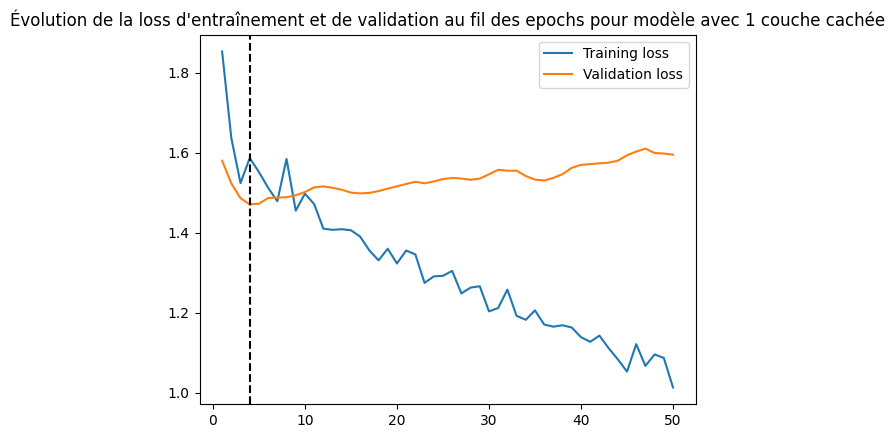

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(np.arange(1, 51), i.history["loss"], label="Training loss")
plt.plot(np.arange(1, 51), i.history["val_loss"], label="Validation loss")
plt.axvline(x=np.argmin(i.history["val_loss"]) + 1, color='k', linestyle='--')
plt.title("Évolution de la loss d'entraînement et de validation au fil des epochs pour modèle avec 1 couche cachée")
plt.legend();

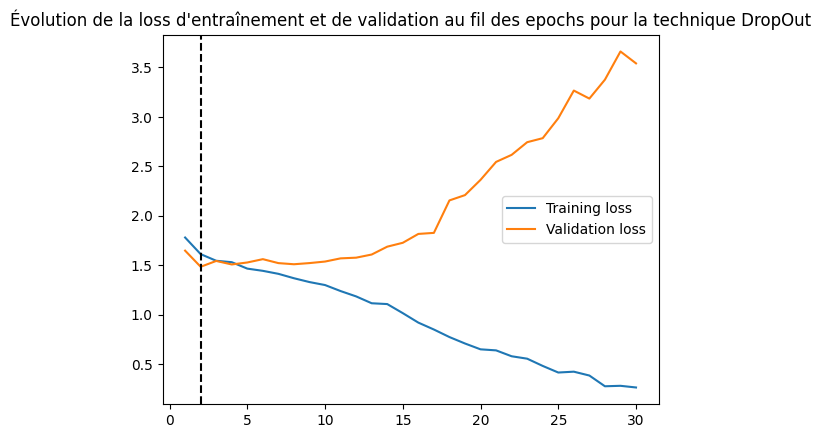

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

epochs = 30  # Modifiez ceci en fonction du nombre réel d'époques pour lesquelles vous avez entraîné le modèle
plt.plot(np.arange(1, epochs + 1), h.history["loss"], label="Training loss")
plt.plot(np.arange(1, epochs + 1), h.history["val_loss"], label="Validation loss")
plt.axvline(x=np.argmin(h.history["val_loss"]) + 1, color='k', linestyle='--')
plt.title("Évolution de la loss d'entraînement et de validation au fil des epochs pour la technique DropOut")
plt.legend()
plt.show()

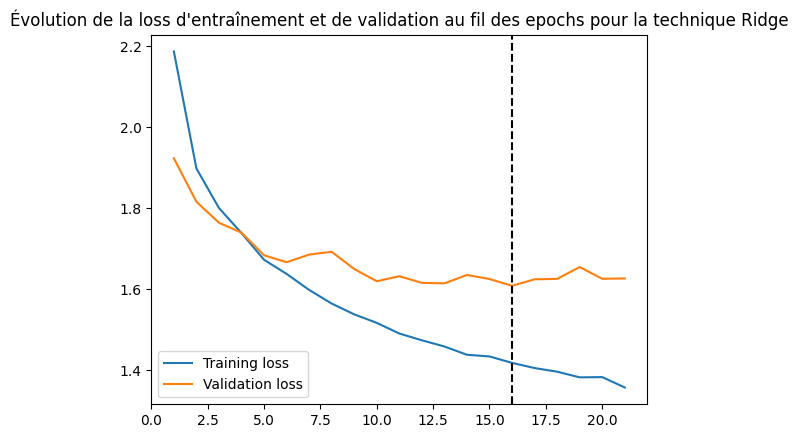

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

epochs = 21
plt.plot(np.arange(1, epochs + 1), j.history["loss"], label="Training loss")
plt.plot(np.arange(1, epochs + 1), j.history["val_loss"], label="Validation loss")
plt.axvline(x=np.argmin(j.history["val_loss"]) + 1, color='k', linestyle='--')
plt.title("Évolution de la loss d'entraînement et de validation au fil des epochs pour la technique Ridge")
plt.legend()
plt.show()

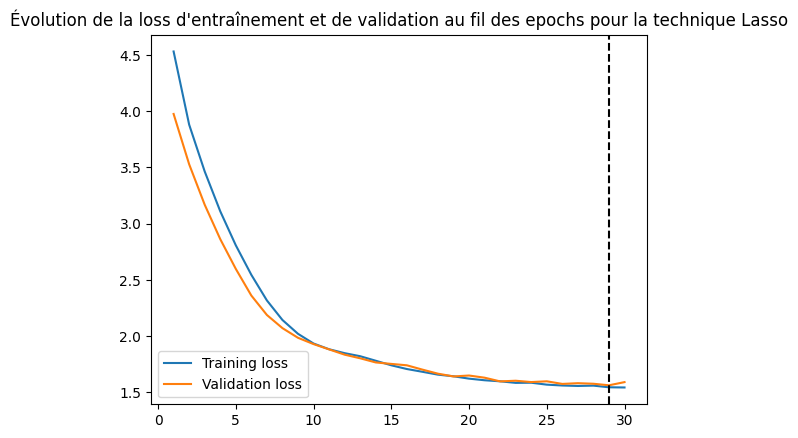

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

epochs = 30
plt.plot(np.arange(1, epochs + 1), k.history["loss"], label="Training loss")
plt.plot(np.arange(1, epochs + 1), k.history["val_loss"], label="Validation loss")
plt.axvline(x=np.argmin(k.history["val_loss"]) + 1, color='k', linestyle='--')
plt.title("Évolution de la loss d'entraînement et de validation au fil des epochs pour la technique Lasso")
plt.legend()
plt.show()

**Analyse de notre jeu de données en introduisant le caractère temporelle de ces dernières (RNN, LSTM)**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Bidirectional, Flatten
from keras.optimizers import Adam
from keras.utils import to_categorical

# Construction de l'encodage de nos données en spécifiant la longueur des séquences
# correspondant au nombre de lignes avant de passer à la prochaine journée de chanmpionnat
def prepare_data_algo_recurrent(df):
    # Séparation des caractéristiques et de la cible pour notre prédiction
    features = df.drop('2EME_PERIODE_NBR_BUTS', axis=1)
    target = df['2EME_PERIODE_NBR_BUTS']

    # Encodage one-hot de toutes les variables catégorielles
    features = pd.get_dummies(features)

    # Normalisation des caractéristiques avec MinMaxScaler
    scaler = MinMaxScaler()
    features_scaled = scaler.fit_transform(features)

    # Encodage de la variable cible en données catégorielles
    target_encoded = to_categorical(target)

    # Reformater les données en séquences pour un RNN
    sequence_length = 10  # Séquence de 10 matchs représente 1 journée de championnat
    x_rnn, y_rnn = [], []

    for i in range(len(features_scaled) - sequence_length + 1):
        x_rnn.append(features_scaled[i:i+sequence_length, :])
        y_rnn.append(target_encoded[i+sequence_length-1])

    x_rnn = np.array(x_rnn)
    y_rnn = np.array(y_rnn)

    # Séparation des données en ensembles d'entraînement et de test
    x_train_r, x_test_r, y_train_r, y_test_r = train_test_split(x_rnn, y_rnn, test_size=0.2, random_state=42)

    return x_train_r, x_test_r, y_train_r, y_test_r

# Préparation des données
x_train_r, x_test_r, y_train_r, y_test_r = prepare_data_algo_recurrent(df)



Réseau RNN

In [ ]:
# Utilisation d'1 couche récurrente RNN
# Création du modèle RNN
sequence_length = 10 # Séquence de 10 matchs représente 1 journée de championnat
model_rnn = Sequential()
model_rnn.add(SimpleRNN(units=64, input_shape=(sequence_length, x_train_r.shape[2])))
model_rnn.add(Dense(units=7, activation='softmax'))

# Compilation du modèle
model_rnn.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])

# Entraînement du modèle
model_rnn.fit(x_train_r, y_train_r, epochs=20, batch_size=32, validation_data=(x_test_r, y_test_r), verbose=2)



Epoch 1/20
8/8 - 3s - loss: 1.7334 - accuracy: 0.2383 - val_loss: 1.8394 - val_accuracy: 0.2769 - 3s/epoch - 351ms/step
Epoch 2/20
8/8 - 0s - loss: 1.6151 - accuracy: 0.2969 - val_loss: 1.6017 - val_accuracy: 0.2615 - 75ms/epoch - 9ms/step
Epoch 3/20
8/8 - 0s - loss: 1.5557 - accuracy: 0.3164 - val_loss: 1.5023 - val_accuracy: 0.2769 - 72ms/epoch - 9ms/step
Epoch 4/20
8/8 - 0s - loss: 1.4738 - accuracy: 0.3555 - val_loss: 1.5815 - val_accuracy: 0.2462 - 70ms/epoch - 9ms/step
Epoch 5/20
8/8 - 0s - loss: 1.4034 - accuracy: 0.4141 - val_loss: 1.5652 - val_accuracy: 0.2154 - 92ms/epoch - 12ms/step
Epoch 6/20
8/8 - 0s - loss: 1.3497 - accuracy: 0.4375 - val_loss: 1.7294 - val_accuracy: 0.2769 - 72ms/epoch - 9ms/step
Epoch 7/20
8/8 - 0s - loss: 1.2740 - accuracy: 0.4922 - val_loss: 1.6741 - val_accuracy: 0.2462 - 72ms/epoch - 9ms/step
Epoch 8/20
8/8 - 0s - loss: 1.1640 - accuracy: 0.5391 - val_loss: 1.8800 - val_accuracy: 0.2462 - 73ms/epoch - 9ms/step
Epoch 9/20
8/8 - 0s - loss: 1.0828 - ac

In [ ]:
# Affichage d'un résumé du modèle associé
model_rnn.summary()

Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_7 (SimpleRNN)    (None, 64)                5504      
                                                                 
 dense_93 (Dense)            (None, 7)                 455       
                                                                 
Total params: 5959 (23.28 KB)
Trainable params: 5959 (23.28 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Utilisation de 2 couches récurrentes RNN

sequence_length = 10  # Séquence de 10 matchs représente 1 journée de championnat

model_rnn = Sequential()

# Première couche RNN
model_rnn.add(SimpleRNN(units=64, input_shape=(sequence_length, x_train_r.shape[2]), return_sequences=True))

# Deuxième couche RNN
model_rnn.add(SimpleRNN(units=64))

model_rnn.add(Dense(units=7, activation='softmax'))

# Compilation du modèle
model_rnn.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])

# Entraînement du modèle
model_rnn.fit(x_train_r, y_train_r, epochs=20, batch_size=32, validation_data=(x_test_r, y_test_r), verbose=2)


Epoch 1/20
8/8 - 3s - loss: 1.8854 - accuracy: 0.2461 - val_loss: 1.7340 - val_accuracy: 0.2769 - 3s/epoch - 397ms/step
Epoch 2/20
8/8 - 0s - loss: 1.6059 - accuracy: 0.2734 - val_loss: 1.5493 - val_accuracy: 0.2769 - 133ms/epoch - 17ms/step
Epoch 3/20
8/8 - 0s - loss: 1.5259 - accuracy: 0.2969 - val_loss: 1.6101 - val_accuracy: 0.2462 - 161ms/epoch - 20ms/step
Epoch 4/20
8/8 - 0s - loss: 1.5735 - accuracy: 0.3203 - val_loss: 1.6060 - val_accuracy: 0.2000 - 144ms/epoch - 18ms/step
Epoch 5/20
8/8 - 0s - loss: 1.5657 - accuracy: 0.3047 - val_loss: 1.5467 - val_accuracy: 0.2769 - 143ms/epoch - 18ms/step
Epoch 6/20
8/8 - 0s - loss: 1.5271 - accuracy: 0.3320 - val_loss: 1.5887 - val_accuracy: 0.2769 - 143ms/epoch - 18ms/step
Epoch 7/20
8/8 - 0s - loss: 1.4583 - accuracy: 0.3984 - val_loss: 1.6063 - val_accuracy: 0.3385 - 143ms/epoch - 18ms/step
Epoch 8/20
8/8 - 0s - loss: 1.4297 - accuracy: 0.3906 - val_loss: 1.5754 - val_accuracy: 0.3538 - 140ms/epoch - 17ms/step
Epoch 9/20
8/8 - 0s - loss

**Analyse du réseau récurrent RNN**

On observe avec le réseau récurrent RNN que la précision est très bonne, voir trop (sur apprentissage) certainement pour 1 seule couche pour les données d'entrainements. Néanmoins, elle est beaucoup plus faible concernant les données de test, comparé aux données initiales.

Réseau LSTM

In [ ]:
# Utilisation d'1 couche récurrente LSTM
# Création du modèle LSTM
sequence_length = 10 # Séquence de 10 matchs représente 1 journée de championnat
model_lstm = Sequential()
model_lstm.add(LSTM(units=64, input_shape=(sequence_length, x_train_r.shape[2])))
model_lstm.add(Dense(units=7, activation='softmax'))

# Compilation du modèle
model_lstm.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])

# Entraînement du modèle
model_lstm.fit(x_train_r, y_train_r, epochs=20, batch_size=32, validation_data=(x_test_r, y_test_r), verbose=2)



Epoch 1/20
8/8 - 3s - loss: 1.6102 - accuracy: 0.3164 - val_loss: 1.5767 - val_accuracy: 0.2923 - 3s/epoch - 389ms/step
Epoch 2/20
8/8 - 0s - loss: 1.5133 - accuracy: 0.3594 - val_loss: 1.5732 - val_accuracy: 0.2769 - 141ms/epoch - 18ms/step
Epoch 3/20
8/8 - 0s - loss: 1.4973 - accuracy: 0.3516 - val_loss: 1.5408 - val_accuracy: 0.2769 - 135ms/epoch - 17ms/step
Epoch 4/20
8/8 - 0s - loss: 1.4859 - accuracy: 0.3555 - val_loss: 1.5455 - val_accuracy: 0.2923 - 126ms/epoch - 16ms/step
Epoch 5/20
8/8 - 0s - loss: 1.4765 - accuracy: 0.3555 - val_loss: 1.5685 - val_accuracy: 0.2769 - 135ms/epoch - 17ms/step
Epoch 6/20
8/8 - 0s - loss: 1.4687 - accuracy: 0.3633 - val_loss: 1.5605 - val_accuracy: 0.2769 - 135ms/epoch - 17ms/step
Epoch 7/20
8/8 - 0s - loss: 1.4682 - accuracy: 0.3633 - val_loss: 1.5600 - val_accuracy: 0.3077 - 135ms/epoch - 17ms/step
Epoch 8/20
8/8 - 0s - loss: 1.4490 - accuracy: 0.3789 - val_loss: 1.5830 - val_accuracy: 0.2769 - 124ms/epoch - 15ms/step
Epoch 9/20
8/8 - 0s - loss

In [ ]:
# Utilisation de 2 couches récurrentes LSTMM

sequence_length = 10  # Séquence de 10 matchs représente 1 journée de championnat

model_lstm = Sequential()

# Première couche LSTM
model_lstm.add(LSTM(units=64, input_shape=(sequence_length, x_train_r.shape[2]), return_sequences=True))

# Deuxième couche LSTM
model_lstm.add(LSTM(units=64))

model_lstm.add(Dense(units=7, activation='softmax'))

# Compilation du modèle
model_lstm.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])

# Entraînement du modèle
model_lstm.fit(x_train_r, y_train_r, epochs=20, batch_size=32, validation_data=(x_test_r, y_test_r), verbose=2)


Epoch 1/20
8/8 - 4s - loss: 1.6389 - accuracy: 0.2969 - val_loss: 1.5715 - val_accuracy: 0.2769 - 4s/epoch - 562ms/step
Epoch 2/20
8/8 - 0s - loss: 1.5494 - accuracy: 0.2695 - val_loss: 1.6168 - val_accuracy: 0.2769 - 196ms/epoch - 25ms/step
Epoch 3/20
8/8 - 0s - loss: 1.5191 - accuracy: 0.3516 - val_loss: 1.5308 - val_accuracy: 0.2769 - 203ms/epoch - 25ms/step
Epoch 4/20
8/8 - 0s - loss: 1.5024 - accuracy: 0.3516 - val_loss: 1.5286 - val_accuracy: 0.2769 - 265ms/epoch - 33ms/step
Epoch 5/20
8/8 - 0s - loss: 1.4971 - accuracy: 0.3516 - val_loss: 1.5589 - val_accuracy: 0.2769 - 197ms/epoch - 25ms/step
Epoch 6/20
8/8 - 0s - loss: 1.4976 - accuracy: 0.3516 - val_loss: 1.5464 - val_accuracy: 0.2769 - 196ms/epoch - 24ms/step
Epoch 7/20
8/8 - 0s - loss: 1.4936 - accuracy: 0.3516 - val_loss: 1.5494 - val_accuracy: 0.2769 - 193ms/epoch - 24ms/step
Epoch 8/20
8/8 - 0s - loss: 1.4958 - accuracy: 0.3516 - val_loss: 1.5526 - val_accuracy: 0.2769 - 192ms/epoch - 24ms/step
Epoch 9/20
8/8 - 0s - loss

In [ ]:
# Construction du modèle LSTM bidirectionnel
model_lstm_b = Sequential()

# Ajout de la couche LSTM bidirectionnelle
model_lstm_b.add(Bidirectional(LSTM(units=128, return_sequences=True), input_shape=(x_train_r.shape[1], x_train_r.shape[2])))
model_lstm_b.add(Bidirectional(LSTM(units=128, return_sequences=True)))
model_lstm_b.add(Bidirectional(LSTM(units=64, return_sequences=True)))
model_lstm_b.add(Bidirectional(LSTM(units=64, return_sequences=True)))

# Ajout de la couche Flatten
model_lstm_b.add(Flatten())

# Ajout d'une couche Dense de 32 neurones avec activation relu
model_lstm_b.add(Dense(units=32, activation='relu'))

# Couche Dense finale avec activation softmax (nombre de neurones = nombre de classes)
model_lstm_b.add(Dense(units=y_train_r.shape[1], activation='softmax'))

# Compilation du modèle
model_lstm_b.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])

# Entraînement du modèle
model_lstm_b.fit(x_train_r, y_train_r, epochs=20, batch_size=32, validation_data=(x_test_r, y_test_r), verbose=2)

Epoch 1/20
8/8 - 19s - loss: 2.9137 - accuracy: 0.1484 - val_loss: 1.9393 - val_accuracy: 0.2769 - 19s/epoch - 2s/step
Epoch 2/20
8/8 - 1s - loss: 1.6952 - accuracy: 0.2734 - val_loss: 1.8571 - val_accuracy: 0.2769 - 1s/epoch - 148ms/step
Epoch 3/20
8/8 - 2s - loss: 1.5790 - accuracy: 0.3516 - val_loss: 1.6128 - val_accuracy: 0.2000 - 2s/epoch - 237ms/step
Epoch 4/20
8/8 - 2s - loss: 1.5175 - accuracy: 0.2578 - val_loss: 1.5282 - val_accuracy: 0.2769 - 2s/epoch - 207ms/step
Epoch 5/20
8/8 - 2s - loss: 1.5166 - accuracy: 0.3047 - val_loss: 1.5831 - val_accuracy: 0.2769 - 2s/epoch - 211ms/step
Epoch 6/20
8/8 - 2s - loss: 1.5024 - accuracy: 0.3516 - val_loss: 1.5684 - val_accuracy: 0.2769 - 2s/epoch - 205ms/step
Epoch 7/20
8/8 - 1s - loss: 1.5080 - accuracy: 0.3516 - val_loss: 1.5660 - val_accuracy: 0.2769 - 976ms/epoch - 122ms/step
Epoch 8/20
8/8 - 1s - loss: 1.5031 - accuracy: 0.3516 - val_loss: 1.5378 - val_accuracy: 0.2769 - 952ms/epoch - 119ms/step
Epoch 9/20
8/8 - 1s - loss: 1.4983 

**Analyse du réseau récurrent LSTM**

On constate des résultats plus faibles concernant la précision des données d'entrainements ou de test par rapport à nos données initiales.


**Conclusion**

Dans le cadre de ce projet d'apprentissage profond, nous avons mis en place des modèles comportant plus ou moins de couches de neurones avec différentes fonctions d'activation et différentes techniques pour prédire le nombre de buts inscrits en deuxième période d'un match de football. Les meilleurs résultats obtenus, se situant autour de 30-40% (pour les données de tests), suscitent la réflexion quant à l'interprétation de ces performances. Il est crucial de contextualiser ces chiffres en tenant compte de la nature complexe de la prédiction envisagée. La prévision du nombre de buts dans un match de football n'est pas une tâche linéaire, et par conséquent, il est peu réaliste de s'attendre à des taux de précision élevés, tels que 90% (comme c'est le cas pour d'autres prédictions sur d'autres données). En reconnaissant la complexité relative à ce type de prédiction, nous estimons que les résultats sont plutôt encourageants compte tenu de la complexité associée à la nature non linéaire du jeu de football et à une grande partie aléatoire ce qui rend le sport intéressant à suivre. Par ailleurs, les algorithmes de réseaux récurrents n'ont pas donnée de résultats davantage satisfaisant que ceux initiaux. Il parait important de souligner que nous avons fait le choix arbitraire de prendre en compte les nombres de buts par période sur le 5 derniers matchs pour effectuer notre prédiction, mais dans une volonté d'avoir une information plus exhaustive sur les deux équipes, on aurait pu par exemple recueillir également ce même indicateur mais pour les 5 dernières oppositions entre chaque équipe. On aurait également pu utiliser diverses statisiques avancées attestant de la qualité des occasions créé (Xg) sur ces deux périodes pour le match prédit, ainsi que leurs 5 derniers matchs dans la même idée de ce que nous avons réalisé dans notre devoir. De plus, on peut également penser qu'un jeu de données répertoriant tout ces type d'informations mais sur plusieurs saisons consécutives aurait pu aider nos modèles à mieux prédire ces données, avec un nombre d'epochs plus petit.


**Pour aller plus loin ...**

Nous voulions savoir si les prédictions étaient plus ou moins bonnes en fonction des différentes périodes de la saison. Nous avons divisé la saison (sur laquelle nous avons travaillé) en 3 parties égales. Pour cela, nous comparons les prédictions pour le premier tiers, le milieu et le dernier tiers de la saison. Nous avons ainsi confronté les prédictions de buts pour ces 3 parties de la saison avec un modèle à 1 couche cachée et 30% du jeu de données en validation car c'est une architecture de modèle pour laquelle nous avions eu des résultats plutôt satisfaisant.

**Comparaison de la prédiction au début, au milieu et à la fin de la saison**

In [ ]:
# Calcul des tiers des données
total_samples = len(df)
tiers_debut = total_samples // 3
tiers_milieu = 2 * total_samples // 3

# Diviser les données en trois parties
donnees_debut = df[:tiers_debut]
donnees_milieu = df[tiers_debut:tiers_milieu]
donnees_fin = df[tiers_milieu:]

# Afficher les résultats pour vérifier
print("Données du début:", donnees_debut)
print("Données du milieu:", donnees_milieu)
print("Données de fin:", donnees_fin)

Données du début:      1ERE_PERIODE_NBR_BUTS  2EME_PERIODE_NBR_BUTS  \
50                       1                      1   
51                       2                      3   
52                       1                      2   
53                       2                      2   
54                       0                      1   
..                     ...                    ...   
155                      1                      2   
156                      2                      0   
157                      3                      1   
158                      2                      5   
159                      0                      0   

     dernier_match_1_buts_mi_temps1_dom  dernier_match_1_buts_mi_temps1_ext  \
50                                    1                                   0   
51                                    1                                   2   
52                                    1                                   1   
53                           

**Début de saison**

In [ ]:
# Construction d'un premier modèle avec comme optimiseur adam et seulement 1 couche de sortie
import tensorflow as tf

x_train, x_test, y_train, y_test = prepare_data(donnees_debut)

# On définit le callback EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Construction d'un modèle avec 1 couche cachée ayant pour fonction d'activation 'relu'
model = Sequential([
    InputLayer(input_shape=x_train.shape[1:]),
    Dense(units=128, activation="relu"),
    Dense(units=y_train.shape[1], activation="softmax")
])
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
i=model.fit(x_train, y_train, epochs=50, batch_size=100, verbose=2,validation_split=0.3, callbacks = [early_stopping])

Epoch 1/50
1/1 - 1s - loss: 1.8052 - accuracy: 0.1639 - val_loss: 1.7089 - val_accuracy: 0.3704 - 1s/epoch - 1s/step
Epoch 2/50
1/1 - 0s - loss: 1.7758 - accuracy: 0.2131 - val_loss: 1.6888 - val_accuracy: 0.3704 - 70ms/epoch - 70ms/step
Epoch 3/50
1/1 - 0s - loss: 1.7480 - accuracy: 0.2623 - val_loss: 1.6706 - val_accuracy: 0.4074 - 51ms/epoch - 51ms/step
Epoch 4/50
1/1 - 0s - loss: 1.7216 - accuracy: 0.2787 - val_loss: 1.6543 - val_accuracy: 0.4074 - 56ms/epoch - 56ms/step
Epoch 5/50
1/1 - 0s - loss: 1.6965 - accuracy: 0.2623 - val_loss: 1.6394 - val_accuracy: 0.4074 - 52ms/epoch - 52ms/step
Epoch 6/50
1/1 - 0s - loss: 1.6730 - accuracy: 0.2623 - val_loss: 1.6257 - val_accuracy: 0.4074 - 58ms/epoch - 58ms/step
Epoch 7/50
1/1 - 0s - loss: 1.6510 - accuracy: 0.2623 - val_loss: 1.6133 - val_accuracy: 0.4074 - 72ms/epoch - 72ms/step
Epoch 8/50
1/1 - 0s - loss: 1.6301 - accuracy: 0.2623 - val_loss: 1.6024 - val_accuracy: 0.4074 - 72ms/epoch - 72ms/step
Epoch 9/50
1/1 - 0s - loss: 1.6104 -

**Milieu de saison**

In [ ]:
# Construction d'un premier modèle avec comme optimiseur adam et seulement 1 couche de sortie
import tensorflow as tf

x_train, x_test, y_train, y_test = prepare_data(donnees_milieu)

# On définit le callback EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Construction d'un modèle avec 1 couche cachée ayant pour fonction d'activation 'relu'
model = Sequential([
    InputLayer(input_shape=x_train.shape[1:]),
    Dense(units=128, activation="relu"),
    Dense(units=y_train.shape[1], activation="softmax")
])
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
i=model.fit(x_train, y_train, epochs=50, batch_size=100, verbose=2,validation_split=0.3, callbacks = [early_stopping])

Epoch 1/50
1/1 - 2s - loss: 1.9353 - accuracy: 0.1148 - val_loss: 1.8614 - val_accuracy: 0.2963 - 2s/epoch - 2s/step
Epoch 2/50
1/1 - 0s - loss: 1.8975 - accuracy: 0.2295 - val_loss: 1.8293 - val_accuracy: 0.3704 - 90ms/epoch - 90ms/step
Epoch 3/50
1/1 - 0s - loss: 1.8616 - accuracy: 0.2131 - val_loss: 1.7989 - val_accuracy: 0.5185 - 85ms/epoch - 85ms/step
Epoch 4/50
1/1 - 0s - loss: 1.8274 - accuracy: 0.3115 - val_loss: 1.7699 - val_accuracy: 0.5556 - 64ms/epoch - 64ms/step
Epoch 5/50
1/1 - 0s - loss: 1.7950 - accuracy: 0.3443 - val_loss: 1.7426 - val_accuracy: 0.5556 - 83ms/epoch - 83ms/step
Epoch 6/50
1/1 - 0s - loss: 1.7642 - accuracy: 0.3443 - val_loss: 1.7167 - val_accuracy: 0.5556 - 81ms/epoch - 81ms/step
Epoch 7/50
1/1 - 0s - loss: 1.7350 - accuracy: 0.3443 - val_loss: 1.6923 - val_accuracy: 0.5556 - 75ms/epoch - 75ms/step
Epoch 8/50
1/1 - 0s - loss: 1.7074 - accuracy: 0.3607 - val_loss: 1.6691 - val_accuracy: 0.5556 - 83ms/epoch - 83ms/step
Epoch 9/50
1/1 - 0s - loss: 1.6813 -

**Fin de saison**

In [ ]:
# Construction d'un premier modèle avec comme optimiseur adam et seulement 1 couche de sortie
import tensorflow as tf

x_train, x_test, y_train, y_test = prepare_data(donnees_fin)

# On définit le callback EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Construction d'un modèle avec 1 couche cachée ayant pour fonction d'activation 'relu'
model = Sequential([
    InputLayer(input_shape=x_train.shape[1:]),
    Dense(units=128, activation="relu"),
    Dense(units=y_train.shape[1], activation="softmax")
])
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
i=model.fit(x_train, y_train, epochs=50, batch_size=100, verbose=2,validation_split=0.3, callbacks = [early_stopping])

Epoch 1/50
1/1 - 1s - loss: 2.1640 - accuracy: 0.0326 - val_loss: 2.0014 - val_accuracy: 0.0750 - 689ms/epoch - 689ms/step
Epoch 2/50
1/1 - 0s - loss: 2.1200 - accuracy: 0.0435 - val_loss: 1.9661 - val_accuracy: 0.0750 - 35ms/epoch - 35ms/step
Epoch 3/50
1/1 - 0s - loss: 2.0778 - accuracy: 0.0870 - val_loss: 1.9329 - val_accuracy: 0.1000 - 36ms/epoch - 36ms/step
Epoch 4/50
1/1 - 0s - loss: 2.0373 - accuracy: 0.1304 - val_loss: 1.9010 - val_accuracy: 0.1500 - 34ms/epoch - 34ms/step
Epoch 5/50
1/1 - 0s - loss: 1.9986 - accuracy: 0.1848 - val_loss: 1.8701 - val_accuracy: 0.2500 - 39ms/epoch - 39ms/step
Epoch 6/50
1/1 - 0s - loss: 1.9617 - accuracy: 0.2609 - val_loss: 1.8406 - val_accuracy: 0.3500 - 31ms/epoch - 31ms/step
Epoch 7/50
1/1 - 0s - loss: 1.9264 - accuracy: 0.2935 - val_loss: 1.8122 - val_accuracy: 0.4250 - 31ms/epoch - 31ms/step
Epoch 8/50
1/1 - 0s - loss: 1.8928 - accuracy: 0.3261 - val_loss: 1.7851 - val_accuracy: 0.4750 - 31ms/epoch - 31ms/step
Epoch 9/50
1/1 - 0s - loss: 1.

**Analyse des prédictions pour différentes parties de la saison**

On constate que les prédictions ne sont pas les mêmes en fonction de la partie de la saison. En effet, ces dernières sont meilleures pour le début et le milieu de la saison que pour la fin de la saison. Il y a plusieurs raisons possibles pour lesquelles les résultats de prédiction peuvent varier en fonction du découpage de la saison.

Il y a la variabilité des performances des équipes au fil de la saison. Les équipes peuvent avoir des performances variables au cours d'une saison en raison de nombreux facteurs tels que les blessures, les suspensions, les transferts de joueurs, etc. Ce sont des variations que nous n'avons pas et que nous ne pouvons pas prendre en compte dans nos modèles. Cela peut affecter les performances de nos modèles.
Il y a également l'évolution des stratégies de jeu. Les équipes peuvent ajuster leurs stratégies de jeu au fil de la saison en fonction de leurs performances antérieures, des adversaires rencontrés, et d'autres facteurs. Notre modèle avec des variables de base n'est pas capable de capturer ces évolutions au fil du temps, et cela peut conduire à des performances variables.
Il y a également un effet de la dynamique de la saison. Il se peut que certains paramètres ou caractéristiques aient une influence plus forte à différents moments de la saison. Par exemple, des facteurs tels que la fatigue des joueurs, les conditions météorologiques ou les enjeux des matches peuvent varier au fil du temps et influencer les performances.

Toutes ces informations induisent que les prédictions sont censées être meilleurs lorsque l'on fait des prédictions sur certaines parties de la saison car la dynamique du moment est mieux capturée. C'est ce que l'on observe. Les prédictions semblent meilleurs lorsque l'on découpe la saison par rapport à lorsque l'on prédit sur la saison entière. Néanmoins, il important de noter que dans notre cas, lorsque l'on découpe la saison en 3, cela nous ramène à des jeux de données relativement petits. Cela peut expliquer pourquoi il y a peu de variations notamment dans les accuracy de validation. C'est pour cette raison qu'il faut tout de même prendre ces résultats avec précaution.  

